# Import library

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy, copy
import functools

In [2]:
import cProfile
import pstats
from multiprocessing import Pool

## Random seed

In [3]:
RANDOM_SEED = 18
np.random.seed(RANDOM_SEED)

# Function to transform the data

In [4]:
# Function to transfer from dBW to W (power)
def db2pow(db: float) -> float:
    return 10**(db/10)

# Function to transfer from W to dBW (power)
def pow2db(pow: float) -> float:
    return 10*np.log10(pow)

# Hermitian transpose of a matrix
def HermTranspose(x: np.ndarray) -> np.ndarray:
    return x.conj().T

def chanGen(zeta: float, d: float, dim1: int, dim2: int) -> np.ndarray:
    """Function to generate Rayleigh fading channel coefficients

    Args:
        zeta: ξ is the path loss exponent
        d: the distance between the transmitter and the receiver
        dim1: the number of rows in the channel matrix
        dim2: the number of columns in the channel matrix
    """
    pl_ref: float = -30                                    # pathloss (dBW) at reference distance
    pl: float = db2pow(pl_ref - 10*zeta*np.log10(d))       # pathloss model at distance d
    y: np.ndarray = np.sqrt(0.5*pl)*(np.random.randn(dim1,dim2)\
        + 1j*np.random.randn(dim1,dim2))            # Rayleigh distribution
    return y

## Parameters

In [5]:
sigma = db2pow(-75)                                                                 # noise power
N = 10                                                                              # number of transmit antennas
Nris = 100                                                                          # number of RIS elements
number_of_users = 10                                                                 # number of users
number_of_eavesdroppers = 3                                                         # number of eavesdroppers
zetaAI = 2.2                                                                        # Path loss exponent of the channel between the Alice and the RIS
zetaIB = 2.5                                                                        # Path loss exponent of the channel between the legitimate receivers and the RIS
zetaIE = 2.5                                                                        # Path loss exponent of the channel between the eavesdroppers and the RIS
zetaAB = 3.5                                                                        # Path loss exponent of the channel between the Alice and the legitimate receivers
zetaAE = 3.5                                                                        # Path loss exponent of the channel between the Alice and the eavesdroppers

dAI = 50                                                                            # distance between Alice and the RIS
dv = 2                                                                              # Vertical distance between the Alice and the Eve and Bob
dABh = np.random.uniform(5, 10, size=number_of_users)                               # Horizontal distance between Alice and the legitimate receivers
dAEh = np.random.uniform(50, 150, size=number_of_eavesdroppers)                     # Horizontal distance between Alice and the eavesdroppers
dAB = [np.sqrt(dABh[i]**2 + dv**2) for i in range(number_of_users)]                 # Distance between Alice and the legitimate receivers
dAE = [np.sqrt(dAEh[i]**2 + dv**2) for i in range(number_of_eavesdroppers)]         # Distance between Alice and the eavesdroppers
dIB = [np.sqrt((dABh[i]-dAI)**2 + dv**2) for i in range(number_of_users)]           # Distance between the legitimate receivers and the RIS
dIE = [np.sqrt((dAEh[i]-dAI)**2 + dv**2) for i in range(number_of_eavesdroppers)]   # Distance between the eavesdroppers and the RIS

gamma = 0.8 # Lower bound for user's link quality
pmax = 1000  # Maximum transmit power of Alice


In [6]:
def normalise_beamforming_vectors(w: np.ndarray) -> np.ndarray:
    """Function to normalise the beamforming vectors

    Args:
        w: the beamforming vectors
    """
    total_norm_squared = 0
    for i in range(number_of_users):
        total_norm_squared += (np.linalg.norm(w[i]) ** 2)
    if total_norm_squared <= pmax:
        return w
    for i in range(number_of_users):
        w[i] = w[i] / (total_norm_squared ** 0.5) * np.sqrt(pmax)
    return w

def generate_random_beamforming_vector():
  '''
  Generate one random beamforming vector
  '''
  return np.random.uniform(-1, 1, (N, 1)) + 1j * np.random.uniform(-1, 1, (N, 1))

def generate_random_beamforming_vectors():
    # Generate random complex numbers for each element of the beamforming vector
    beamforming_vectors = [generate_random_beamforming_vector() for _ in range (number_of_users)]
    
    # Normalize the vectors
    beamforming_vectors = normalise_beamforming_vectors(beamforming_vectors)
    return beamforming_vectors
    #w: list of beamforming vectors, length = number of users, elements are N x 1

def generate_random_theta():
    theta = np.random.uniform(-np.pi, np.pi, (1, Nris))
    theta = np.exp(1j * theta)
    return theta
    #theta: phase shift of RIS, size 1 x Nris

def generate_random_theta_angles(size: int):
  """
    Generate a random vector of angles from -pi to pi
  """
  return np.random.uniform(-np.pi, np.pi, size=(1, size))

def theta_angles_to_theta_vector(angles: np.ndarray[np.float64]) -> np.ndarray[np.complex128]:
  """
    Convert a vector of angles to a vector of complex numbers on the unit circle
  """
  return np.exp(1j * angles)

def theta_vector_to_theta_angles(theta: np.ndarray[np.complex128]) -> np.ndarray[np.float64]:
  """
    Convert a vector of complex numbers on the unit circle to a vector of angles
  """
  return np.angle(theta)

def generateChannel():
    normFact: float = 1/np.sqrt(sigma)
    Hai = chanGen(zetaAI, dAI, Nris, N)                                                         # Alice to RIS channel
    hib = [normFact*chanGen(zetaIB, dIB[i], 1, Nris) for i in range(number_of_users)]           # Channel between the RIS and the legitimate receivers
    hie = [normFact*chanGen(zetaIE, dIE[i], 1, Nris) for i in range(number_of_eavesdroppers)]   # Channel between the RIS and the eavesdroppers
    hab = [normFact*chanGen(zetaAB, dAB[i], 1, N) for i in range(number_of_users)]              # Channel between Alice and the legitimate receivers
    hae = [normFact*chanGen(zetaAE, dAE[i], 1, N) for i in range(number_of_eavesdroppers)]      # Channel between Alice and the eavesdroppers
    return Hai, hib, hie, hab, hae

    #Hai: Channel between Alice and RIS: Nris x N  
    #hib: Channel between RIS and users: List of length number_of_users, elements are 1 x Nris
    #hab: Channel between Alice and users: List of length number_of_users, elements are 1 x N
    #hie: Channel between RIS and eavesdroppers: List of length number_of_eavesdroppers, elements are 1 x Nris
    #hae: Channel between Alice and eavesdroppers: List of length number_of_eavesdroppers, elements are 1 x N

In [7]:
# Reseed
# np.random.seed(RANDOM_SEED)

# Channel generation
Hai, hib, hie, hab, hae = generateChannel()

# Generate random theta and w
theta_init = generate_random_theta()
w_init = generate_random_beamforming_vectors()

# Objective Function

In [8]:
def secrecy_rate_objective_function(theta, w) -> float:
    secrecy_rate: float = 0
    for k in range(number_of_users):
        R_bk = []
        # Legitimate user k
        Z_bk = hib[k] @ np.diag(theta.flatten()) @ Hai + hab[k]
        numGamma_bk = np.abs(Z_bk @ w[k])**2
        denGamma_bk = 1 + np.sum([np.abs(Z_bk @ w[i])**2 for i in range(number_of_users) if i != k])
        gamma_bk = numGamma_bk/denGamma_bk
        C_bk = np.log2(1 + gamma_bk)
        
        for m in range(number_of_eavesdroppers):
            # Eavesdropper i
            Z_em = hie[m] @ np.diag(theta.flatten()) @ Hai + hae[m]
            numGamma_em = np.abs(Z_em @ w[k])**2
            denGamma_em = 1 + np.sum([np.abs(Z_em @ w[j])**2 for j in range(number_of_users) if j != k])
            gamma_em = numGamma_em/denGamma_em
            C_em = np.log2(1 + gamma_em)
            R_bk.append(C_bk - C_em)
        
        secrecy_rate += max(min(R_bk),0)

    # Return the only element in the matrix as it is currently a 1x1 np array
    return secrecy_rate[0, 0]

# Check if the current set up is valid (every users' C_bk >= gamma)
# Returns the index of the invalid user whose C_bk is highest among the invalid or -1 if all users are valid
def check_validity(theta, w) -> int:
    user = -1
    maxx = 0
    for k in range(number_of_users):
        # Legitimate user k
        Z_bk = hib[k] @ np.diag(theta.flatten()) @ Hai + hab[k]
        numGamma_bk = np.abs(Z_bk @ w[k])**2
        denGamma_bk = 1 + np.sum([np.abs(Z_bk @ w[i])**2 for i in range(number_of_users) if i != k])
        gamma_bk = numGamma_bk/denGamma_bk
        C_bk = np.log2(1 + gamma_bk)
        
        if (C_bk < gamma):
            if C_bk > maxx:
                maxx = C_bk
                user = k
    return user

# Print the C_bk of each user
def print_users_Cbk(theta, w) -> None:
    for k in range(number_of_users):
        # Legitimate user k
        Z_bk = hib[k] @ np.diag(theta.flatten()) @ Hai + hab[k]
        numGamma_bk = np.abs(Z_bk @ w[k])**2
        denGamma_bk = 1 + np.sum([np.abs(Z_bk @ w[i])**2 for i in range(number_of_users) if i != k])
        gamma_bk = numGamma_bk/denGamma_bk
        C_bk = np.log2(1 + gamma_bk)
        print(float(C_bk), end = " ")
    print()

# Calculate the C_bk of a user
def calculate_user_Cbk(theta, w, user) -> float:
    Z_bk = hib[user] @ np.diag(theta.flatten()) @ Hai + hab[user]
    numGamma_bk = np.abs(Z_bk @ w[user])**2
    denGamma_bk = 1 + np.sum([np.abs(Z_bk @ w[i])**2 for i in range(number_of_users) if i != user])
    gamma_bk = numGamma_bk/denGamma_bk
    C_bk = np.log2(1 + gamma_bk)
    return C_bk

# Using gradient descent to repair the beamforming vector of a user
# Try to make that user's C_bk >= gamma
def repair_beamforming_vectors(theta, w, user, learning_rate = 0.01, max_iter = 500):
    #print("Initial norm of user beamforming vector: ", np.linalg.norm(w[user]))
    #print("Before update beamforming of user ", user, ": ")
    #print_users_Cbk(theta, w)
    while (calculate_user_Cbk(theta, w, user) < gamma + 0.2 and max_iter > 0):
        Z_bk = hib[user] @ np.diag(theta.flatten()) @ Hai + hab[user]
        numGamma_bk = np.abs(Z_bk @ w[user])**2
        denGamma_bk = 1 + np.sum([np.abs(Z_bk @ w[i])**2 for i in range(number_of_users) if i != user])
        gamma_bk = numGamma_bk/denGamma_bk
        
        num_grad_C_bk_to_w_k = 2 * (HermTranspose(Z_bk) @ Z_bk @ w[user])
        den_grad_C_bk_to_w_k = (1 + gamma_bk) * np.log(2) * (1 + sum([abs(Z_bk @ w[j]) for j in range (number_of_users) if j != user]))
        grad_C_bk_to_w_k = num_grad_C_bk_to_w_k / den_grad_C_bk_to_w_k
        w[user] = w[user] + learning_rate * grad_C_bk_to_w_k
        #w[user] *= 2
        max_iter -= 1

        w = normalise_beamforming_vectors(w)
    #print("New norm of user beamforming vector: ", np.linalg.norm(w[user]))
    #print("After update beamforming of user ", user, ": ")
    #print_users_Cbk(theta, w)
    return w

# Using gradient descent to repair the whole (theta, w) set up
def repair(theta, w, iter = 100):
    invalid_user = check_validity(theta, w)
    while (invalid_user != -1 and iter > 0):
        w = repair_beamforming_vectors(theta, w, invalid_user)
        invalid_user = check_validity(theta, w)
        iter -= 1
    if (invalid_user != -1):
        theta, w = generate_random_theta(), generate_random_beamforming_vectors()
        return repair(theta, w)
    return theta, w

    


In [9]:
# print(theta_init)
print("distance between Alice and the receivers: ", dAB)
print("distance between Alice and the eavesdroppers: ", dAE)
print("Secrecy Rate:", secrecy_rate_objective_function(theta_init, w_init))

distance between Alice and the receivers:  [8.490781968990742, 7.788436718125179, 9.603571583724229, 6.238482023509884, 9.474660073970615, 8.976325835141209, 8.567226456673964, 10.13869852751857, 6.595395392664417, 5.516822173929771]
distance between Alice and the eavesdroppers:  [113.58952016905081, 134.74608229833302, 123.63364039696921]
Secrecy Rate: 2.405041669607317


# Method

## Gradient Descent for Maximization (GD)

In [10]:
def compute_gradient_w(theta, w):
    grad_w = []
    Z_e_max = [] #Z_e_max[k] = Z_e_max for user k
    gamma_e_max = [] #gamma_e_max[k] = gamma_e_max for user k
    Z_b = [] #Z_b[k] = Z_bk
    gamma_b = [] #gamma_b[k] = gamma_bk
    counted = [] #counted[k] = true if gamma_k > gamma_e_max[k]
    
    #Precalculation 
    for k in range(number_of_users):
        gamma_e = []
        for m in range (number_of_eavesdroppers):
            Z_em = hie[m] @ np.diag(theta.flatten()) @ Hai + hae[m]
            numGamma_em = np.abs(Z_em @ w[k])**2
            denGamma_em = 1 + np.sum([np.abs(Z_em @ w[j])**2 for j in range(number_of_users) if j != k])
            gamma_em = numGamma_em/denGamma_em
            gamma_e.append(gamma_em)
        
        gamma_e_max.append(max(gamma_e))
        index_e_max = gamma_e.index(max(gamma_e))
        Z_e = hie[index_e_max] @ np.diag(theta.flatten()) @ Hai + hae[index_e_max]
        Z_e_max.append(Z_e)

        Z_bk = hib[k] @ np.diag(theta.flatten()) @ Hai + hab[k]
        numGamma_bk = np.abs(Z_bk @ w[k])**2
        denGamma_bk = 1 + np.sum([np.abs(Z_bk @ w[i])**2 for i in range(number_of_users) if i != k])
        gamma_bk = numGamma_bk/denGamma_bk

        Z_b.append(Z_bk)
        gamma_b.append(gamma_bk)

        counted.append(gamma_bk > gamma_e[index_e_max])


    #Calculating grad for i-th beamforming vector
    for i in range(number_of_users):
        grad = np.zeros((N, 1))
        for k in range (number_of_users):
            if (counted[k] == False):
                continue
            if (k == i):
                num_grad_C_bk_to_w_k = 2 * (HermTranspose(Z_b[k]) @ Z_b[k] @ w[k])
                den_grad_C_bk_to_w_k = (1 + gamma_b[k]) * np.log(2) * (1 + sum([abs(Z_b[k] @ w[j]) for j in range (number_of_users) if j != k]))
                grad_C_bk_to_w_k = num_grad_C_bk_to_w_k / den_grad_C_bk_to_w_k

                num_grad_C_e_max_to_w_k = 2 * (HermTranspose(Z_e_max[k]) @ Z_e_max[k] @ w[k])
                den_grad_C_e_max_to_w_k = (1 + gamma_e_max[k]) * np.log(2) * (1 + sum([abs(Z_e_max[k] @ w[j]) for j in range (number_of_users) if j != k]))
                grad_C_e_max_to_w_k = num_grad_C_e_max_to_w_k / den_grad_C_e_max_to_w_k
                
                grad = grad - (grad_C_bk_to_w_k - grad_C_e_max_to_w_k)
            else:
                num_grad_C_bk_to_w_i = -2 * abs(Z_b[k] @ w[k]) * (HermTranspose(Z_b[k]) @ Z_b[k] @ w[i])
                den_grad_C_bk_to_w_i = (1 + gamma_b[k]) * np.log(2) * (1 + sum([abs(Z_b[k] @ w[j]) for j in range (number_of_users) if j != k])) ** 2
                grad_C_bk_to_w_i = num_grad_C_bk_to_w_i / den_grad_C_bk_to_w_i

                num_grad_C_e_max_to_w_i = -2 * abs(Z_e_max[k] @ w[k]) * (HermTranspose(Z_e_max[k]) @ Z_e_max[k] @ w[i])
                den_grad_C_e_max_to_w_i = (1 + gamma_e_max[k]) * np.log(2) * (1 + sum([abs(Z_e_max[k] @ w[j]) for j in range (number_of_users) if j != k])) ** 2
                grad_C_e_max_to_w_i = num_grad_C_e_max_to_w_i / den_grad_C_e_max_to_w_i

                grad = grad - (grad_C_bk_to_w_i - grad_C_e_max_to_w_i)
            
        grad_w.append(grad)
    return grad_w

def compute_gradient_theta_central(theta, w, epsilon=1e-3):
    perturbation = epsilon #+ epsilon * 1j
    grad_theta = []
    for i in range(Nris):
        theta_plus = copy(theta)
        theta_plus[0, i] += perturbation
        theta_minus = copy(theta)
        theta_minus[0, i] -= perturbation
        grad_theta_i = (secrecy_rate_objective_function(theta_plus, w) - secrecy_rate_objective_function(theta_minus, w)) / (2*epsilon)
        grad_theta.append(grad_theta_i)
            
    return np.array(grad_theta)

def compute_gradient_theta_forward(theta, w, original_secrecy_rate=None, epsilon=1e-3):
    """
    Faster implementation of the gradient calculation

    Improvements:
    - Use forward difference instead of central difference
    """
    perturbation = epsilon + epsilon * 1j
    grad_theta = []
    for i in range(Nris):
        theta_plus = copy(theta)
        theta_plus[0, i] += perturbation
        grad_theta_i = (secrecy_rate_objective_function(theta_plus, w) - original_secrecy_rate) / epsilon
        grad_theta.append(grad_theta_i)

    return np.array(grad_theta)

def compute_gradient_theta(theta, w):
    Z_e_max = [] #Z_e_max[k] = Z_e_max for user k
    gamma_e_max = [] #gamma_e_max[k] = gamma_e_max for user k
    Z_b = [] #Z_b[k] = Z_bk
    gamma_b = [] #gamma_b[k] = gamma_bk
    counted = [] #counted[k] = true if gamma_k > gamma_e_max[k]
    index_e_max_list = []
    #Precalculation
    for k in range(number_of_users):
        gamma_e = []
        for m in range (number_of_eavesdroppers):
            Z_em = hie[m] @ np.diag(theta.flatten()) @ Hai + hae[m]
            numGamma_em = np.abs(Z_em @ w[k])**2
            denGamma_em = 1 + np.sum([np.abs(Z_em @ w[j])**2 for j in range(number_of_users) if j != k])
            gamma_em = numGamma_em/denGamma_em
            gamma_e.append(gamma_em)
        
        gamma_e_max.append(max(gamma_e))
        index_e_max = gamma_e.index(max(gamma_e))
        index_e_max_list.append(index_e_max)
        Z_e = hie[index_e_max] @ np.diag(theta.flatten()) @ Hai + hae[index_e_max]
        Z_e_max.append(Z_e)

        Z_bk = hib[k] @ np.diag(theta.flatten()) @ Hai + hab[k]
        numGamma_bk = np.abs(Z_bk @ w[k])**2
        denGamma_bk = 1 + np.sum([np.abs(Z_bk @ w[i])**2 for i in range(number_of_users) if i != k])
        gamma_bk = numGamma_bk/denGamma_bk

        Z_b.append(Z_bk)
        gamma_b.append(gamma_bk)

        counted.append(gamma_bk > gamma_e[index_e_max])


    grad_theta = 0


    for k in range(number_of_users):
        if (counted[k] == False):
            continue

        grad_Z_bk_wk_to_theta = (1/sigma) * np.diag(hib[k].flatten()) @ Hai @ w[k]
        grad_gamma_bk_to_theta_first_term = (2 * (Z_b[k] @ w[k]) * grad_Z_bk_wk_to_theta) * (1 + sum([np.linalg.norm(Z_b[k] @ w[j])**2 for j in range (number_of_users) if j != k]))
        grad_gamma_bk_to_theta_second_term = sum([2 * (Z_b[k] @ w[j]) * grad_Z_bk_wk_to_theta for j in range(number_of_users) if j != k]) * (np.linalg.norm(Z_b[k] @ w[k]) ** 2)
        grad_gamma_bk_to_theta_third_term = (1 + sum([np.linalg.norm(Z_b[k] @ w[j]) for j in range (number_of_users) if j != k])**2) ** 2
        grad_gamma_bk_to_theta = (grad_gamma_bk_to_theta_first_term - grad_gamma_bk_to_theta_second_term) / grad_gamma_bk_to_theta_third_term

        grad_C_bk_to_theta = 1 / ((1 + gamma_b[k]) * np.log(2)) * grad_gamma_bk_to_theta

        grad_Z_emax_wk_to_theta = (1/sigma) * np.diag(hie[index_e_max_list[k]].flatten()) @ Hai @ w[k]

        grad_gamma_emax_to_theta_first_term = (2 * (Z_e_max[k] @ w[k]) * grad_Z_emax_wk_to_theta) * (1 + sum([np.linalg.norm(Z_e_max[k] @ w[j])**2 for j in range (number_of_users) if j != k]))
        grad_gamma_emax_to_theta_second_term = sum([2 * (Z_e_max[k] @ w[j]) * grad_Z_emax_wk_to_theta for j in range(number_of_users) if j != k]) * (np.linalg.norm(Z_e_max[k] @ w[k]) ** 2)
        grad_gamma_emax_to_theta_third_term = (1 + sum([np.linalg.norm(Z_e_max[k] @ w[j]) for j in range (number_of_users) if j != k])**2) ** 2
        grad_gamma_emax_to_theta = (grad_gamma_emax_to_theta_first_term - grad_gamma_emax_to_theta_second_term) / grad_gamma_emax_to_theta_third_term

        grad_C_emax_to_theta = 1 / ((1 + gamma_e_max[k]) * np.log(2)) * grad_gamma_emax_to_theta

        grad_theta -= (grad_C_bk_to_theta - grad_C_emax_to_theta)
    
    return np.array(grad_theta).reshape((1, Nris))
    


def gradient_descent_update(w, theta, learning_rate, original_secrecy_rate=None):
    grad_w = compute_gradient_w(theta, w)
    grad_theta = compute_gradient_theta(theta, w)
    w_new = [w[i] - learning_rate * grad_w[i] for i in range (number_of_users)]
    w_new = normalise_beamforming_vectors(w_new)
        
    theta_new = theta - learning_rate * grad_theta
    theta_new = np.exp(1j * np.angle(theta_new))

    return w_new, theta_new

In [11]:
# Reseed first
np.random.seed(RANDOM_SEED)

# Gradient Descent Algorithm
num_cycles = 500
learning_rate = 0.01
theta_GD = generate_random_theta()
w_GD = generate_random_beamforming_vectors()
theta_GD, w_GD = repair(theta_GD, w_GD)
print("Initial Secrecy Rate GD:", secrecy_rate_objective_function(theta_GD, w_GD))
current_secrecy_rate = secrecy_rate_objective_function(theta_GD, w_GD)

GD_results = []
GD_results.append(current_secrecy_rate)

for i in range(num_cycles):
    print("Iteration", i)
    print("Secrecy Rate:", current_secrecy_rate)
    w_new, theta_new = gradient_descent_update(w_GD, theta_GD, learning_rate, original_secrecy_rate=current_secrecy_rate)
    #if check_validity(theta_new, w_new) == False:
    #    print("Stop by invalidity")
    #    break
    new_secrecy_rate = secrecy_rate_objective_function(theta_new, w_new)
    if (new_secrecy_rate - current_secrecy_rate) < 1e-9:
        print("Converged")
        break
    w_GD = w_new
    theta_GD = theta_new
    GD_results.append(new_secrecy_rate)
    current_secrecy_rate = new_secrecy_rate

theta_GD, w_GD = repair(theta_GD, w_GD)
#print(GD_results)
print("Final Secrecy Rate GD:", secrecy_rate_objective_function(theta_GD, w_GD))
print_users_Cbk(theta_GD, w_GD)

Initial Secrecy Rate GD: 8.699681395518992
Iteration 0
Secrecy Rate: 8.699681395518992
Iteration 1
Secrecy Rate: 8.901927576581638
Iteration 2
Secrecy Rate: 9.080896832818697
Iteration 3
Secrecy Rate: 9.244444622040335
Iteration 4
Secrecy Rate: 9.40418182148963
Iteration 5
Secrecy Rate: 9.558978996319762
Iteration 6
Secrecy Rate: 9.708608369689669
Iteration 7
Secrecy Rate: 9.85306946927965
Iteration 8
Secrecy Rate: 9.992404573354381
Iteration 9
Secrecy Rate: 10.126692563097183
Iteration 10
Secrecy Rate: 10.25604216228187
Iteration 11
Secrecy Rate: 10.380444687253885
Iteration 12
Secrecy Rate: 10.499771925204728
Iteration 13
Secrecy Rate: 10.614019325408291
Iteration 14
Secrecy Rate: 10.723003815574728
Iteration 15
Secrecy Rate: 10.824711845591866
Iteration 16
Secrecy Rate: 10.925911096762182
Iteration 17
Secrecy Rate: 11.023135975565388
Iteration 18
Secrecy Rate: 11.116269529925304
Iteration 19
Secrecy Rate: 11.205923007806987
Iteration 20
Secrecy Rate: 11.292325227857422
Iteration 21


/var/folders/bp/42yb86gx3r173cz1j7dwvd5h0000gn/T/ipykernel_2557/4042312889.py:54: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(float(C_bk), end = " ")


## Particle Swarm Optimization (PSO)

In [12]:
class PSOParticle:
  def __init__(self) -> None:
    self.theta = generate_random_theta_angles(Nris)
    self.w = generate_random_beamforming_vectors()
    self.theta, self.w = repair(self.theta, self.w)
    self.best_theta = deepcopy(self.theta)
    self.best_w = deepcopy(self.w)
    self.best_secrecy_rate = secrecy_rate_objective_function(theta_angles_to_theta_vector(self.best_theta), self.best_w)
    self.current_secrecy_rate = secrecy_rate_objective_function(theta_angles_to_theta_vector(self.theta), self.w)
    self.velocity_theta = np.zeros((1, Nris))
    self.velocity_w = [np.zeros((N, 1)) for i in range(number_of_users)]

  
  def update_velocity(self, inertia, c1, c2, global_best_theta, global_best_w):
    r1 = np.random.rand()
    r2 = np.random.rand()
    self.velocity_theta = inertia * self.velocity_theta + c1 * r1 * (self.best_theta - self.theta) + c2 * r2 * (global_best_theta - self.theta)
    self.velocity_w = [inertia * self.velocity_w[i] + c1 * r1 * (self.best_w[i] - self.w[i]) + c2 * r2 * (global_best_w[i] - self.w[i]) for i in range(number_of_users)]

  def update_position(self):
    self.theta = self.theta + self.velocity_theta
    self.w = [self.w[i] + self.velocity_w[i] for i in range(number_of_users)]
    self.w = normalise_beamforming_vectors(self.w)
    self.theta, self.w = repair(self.theta, self.w)

  def update_velocity_theta(self, inertia, c1, c2, global_best_theta): #Used for PSO_GD
    self.velocity_theta = inertia * self.velocity_theta + c1 * np.random.rand() * (self.best_theta - self.theta) + c2 * np.random.rand() * (global_best_theta - self.theta)
  
  def update_position_theta(self): #Used for PSO_GD
    self.theta = self.theta + self.velocity_theta

  def update_best(self):
    self.theta, self.w = repair(self.theta, self.w)
    self.current_secrecy_rate = secrecy_rate_objective_function(theta_angles_to_theta_vector(self.theta), self.w)
    if self.current_secrecy_rate > self.best_secrecy_rate:
      self.best_secrecy_rate = self.current_secrecy_rate
      self.best_theta = deepcopy(self.theta)
      self.best_w = deepcopy(self.w)

In [13]:
def dynamic_inertia(i: int, max_iter: int, inertia_max: float, inertia_min: float) -> float:
  E_t = float((max_iter - i - 1)/max_iter)
  inertia = inertia_min + (inertia_max - inertia_min) * (2 /(1 + (np.e ** (-5 * E_t))) - 1)
  return inertia

In [14]:
def PSO_optimize_w_theta(max_iter: int, num_particles: int, w_min: float, w_max: float, c1: float, c2: float):
  particles = [PSOParticle() for _ in range(num_particles)]
  global_best_secrecy_rate = -np.inf
  global_best_theta = np.zeros((1, Nris))
  global_best_w = [np.zeros((N, 1)) for i in range(number_of_users)]

  results_secrecy_rate = []

  for particle in particles:
    if particle.best_secrecy_rate > global_best_secrecy_rate:
      global_best_secrecy_rate = particle.best_secrecy_rate
      global_best_theta = deepcopy(particle.best_theta)
      global_best_w = deepcopy(particle.best_w)

  results_secrecy_rate.append(global_best_secrecy_rate)

  for iteration in range(max_iter):
    print("iteration =", iteration, global_best_secrecy_rate)
    inertia = dynamic_inertia(iteration, max_iter, w_max, w_min)

    for particle in particles:
      particle.update_velocity(inertia, c1, c2, global_best_theta, global_best_w)
      particle.update_position()
      particle.update_best()

      if particle.best_secrecy_rate > global_best_secrecy_rate:
        global_best_secrecy_rate = particle.best_secrecy_rate
        global_best_theta = deepcopy(particle.best_theta)
        global_best_w = deepcopy(particle.best_w)

    results_secrecy_rate.append(global_best_secrecy_rate)
   

  return results_secrecy_rate

In [15]:
# Reseed
np.random.seed(RANDOM_SEED)

# PSO Algorithm
max_iter = 200
num_particles = 100
w_min = 0.5
w_max = 0.9
c1 = 1.5
c2 = 1.5

PSO_results = PSO_optimize_w_theta(max_iter, num_particles, w_min, w_max, c1, c2)
print("Initial Secrecy Rate PSO:", PSO_results[0])
print(PSO_results)
print("Final Secrecy Rate PSO:", PSO_results[-1])

iteration = 0 8.698405811598713
iteration = 1 11.244665756531374
iteration = 2 11.35425809694848
iteration = 3 11.35425809694848
iteration = 4 11.35425809694848
iteration = 5 11.35425809694848
iteration = 6 11.35425809694848
iteration = 7 11.371873717912791
iteration = 8 11.623853963255415
iteration = 9 11.867802435078858
iteration = 10 11.867802435078858
iteration = 11 12.082047471243875
iteration = 12 12.082047471243875
iteration = 13 12.082047471243875
iteration = 14 12.082047471243875
iteration = 15 12.082047471243875
iteration = 16 12.082047471243875
iteration = 17 12.44453417516366
iteration = 18 12.44453417516366
iteration = 19 12.44453417516366
iteration = 20 12.44453417516366
iteration = 21 12.44453417516366
iteration = 22 12.44453417516366
iteration = 23 12.44453417516366
iteration = 24 12.44453417516366
iteration = 25 12.44453417516366
iteration = 26 12.44453417516366
iteration = 27 12.44453417516366
iteration = 28 12.44453417516366
iteration = 29 12.44453417516366
iteration

## Genetic Algorithm (GA)

In [16]:
class GAIndividual:
  def __init__(self, theta: np.ndarray[np.float64] = None, w: np.ndarray[np.complex128] = None) -> None:
    if theta is None or w is None:
      self.theta = generate_random_theta_angles(Nris)
      self.w = generate_random_beamforming_vectors()
    else:
      self.theta = theta
      self.w = w
    self.theta, self.w = repair(self.theta, self.w)
    self.update_fitness()
  
  def update_fitness(self):
    self.fitness = secrecy_rate_objective_function(theta_angles_to_theta_vector(self.theta), self.w)


class GAPopulation:
  def __init__(self, population_size: int, crossover_rate: float = 0.85, mutation_rate: float = 0.3) -> None:
    self.population_size = population_size
    self.individuals = [GAIndividual() for _ in range(population_size)]
    self.crossover_rate = crossover_rate
    self.mutation_rate = mutation_rate

  def sort_population(self):
    self.individuals.sort(key=lambda x: x.fitness, reverse=True)

  def filter_population(self):
    self.sort_population()
    self.individuals = self.individuals[:self.population_size]

  def add_individual(self, individual: GAIndividual):
    self.individuals.append(individual)

  def select_parents(self) -> tuple[GAIndividual, GAIndividual]:
    parents = np.random.choice(self.individuals, 2, replace=False)
    return parents[0], parents[1]
  
  def crossover(self, parent1: GAIndividual, parent2: GAIndividual) -> GAIndividual:
    theta1, w1 = parent1.theta, parent1.w
    theta2, w2 = parent2.theta, parent2.w
    theta_child = (theta1 + theta2) / 2
    w_child = [(w1[i] + w2[i]) / 2 for i in range(number_of_users)]
    w_child = normalise_beamforming_vectors(w_child)
    theta_child, w_child = repair(theta_child, w_child)
    return GAIndividual(theta_child, w_child)
  
  def mutate(self, individual: GAIndividual) -> GAIndividual:
    if np.random.rand() < self.mutation_rate:
      mutation_index = np.random.randint(0, Nris)
      individual.theta[0, mutation_index] = np.random.uniform(-np.pi, np.pi)
      mutation_index = np.random.randint(len(individual.w))
      individual.w[mutation_index] = generate_random_beamforming_vector()
      individual.w = normalise_beamforming_vectors(individual.w)
      individual.theta, individual.w = repair(individual.theta, individual.w)
      individual.update_fitness()

    return individual
  
def GA_optimize_w_theta(population_size: int, max_iter: int, crossover_rate: float = 0.85, mutation_rate: float = 0.85):
  population = GAPopulation(population_size, crossover_rate, mutation_rate)
  population.sort_population()
  results_secrecy_rate = []
  results_secrecy_rate.append(population.individuals[0].fitness)

  for iteration in range(max_iter):
    print("iteration =", iteration, population.individuals[0].fitness)
    # Crossover and mutate
    for _ in range(population_size):
      if np.random.rand() < population.crossover_rate:
        parent1, parent2 = population.select_parents()
        child = population.crossover(parent1, parent2)
        population.mutate(child)
        population.add_individual(child)
    # Filter
    population.filter_population()
    
    results_secrecy_rate.append(population.individuals[0].fitness)
    print_users_Cbk(theta_angles_to_theta_vector(population.individuals[0].theta), population.individuals[0].w)
  return results_secrecy_rate

In [17]:
population_size = 100
num_generations = 200
crossover_rate = 0.9
mutation_rate = 0.3

# Reseed
np.random.seed(RANDOM_SEED)

# GA Algorithm
GA_results = GA_optimize_w_theta(population_size, num_generations, crossover_rate, mutation_rate)
print("Initial Secrecy Rate GA:", GA_results[0])
print(GA_results)
print("Final Secrecy Rate GA:", GA_results[-1])

iteration = 0 8.698405811598713


/var/folders/bp/42yb86gx3r173cz1j7dwvd5h0000gn/T/ipykernel_2557/4042312889.py:54: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(float(C_bk), end = " ")


0.9338980339018439 1.4633767390281989 1.0036758866659756 0.9701665486246487 0.8961831765723899 1.454553184564493 0.9740798262019347 0.9681595288111624 1.0184423477866411 0.9318058720031445 
iteration = 1 10.24197660886312
1.0809044559333987 1.2485259033943163 1.2478618802489607 1.016978198770041 0.8984373189114733 0.8337183374095265 0.9394381876355272 0.8992393132840962 1.7886753201490475 0.9301835971446356 
iteration = 2 10.584381652068682
0.8145675158183997 0.9304970603571409 1.625671368449054 0.9109260776376308 1.007136658363999 1.890896513960459 0.9512907158464263 1.002739687533142 0.8336645326268907 1.0787991063957205 
iteration = 3 10.816506909188888
0.8339551517361546 0.8488457372233867 1.1221381960877193 1.0178241877956287 1.3622534598015117 1.5668894713356805 0.8867747954502072 1.5653484379144034 1.0145672585828818 1.1429580419942384 
iteration = 4 11.138319480378708
0.8205290653062892 0.9178902864566946 1.6829101455856659 0.8650352027477135 1.0236605059347956 1.91580791324046

In [18]:
def gradient_descent_update_w_only(w, theta, learning_rate):
    grad_w = compute_gradient_w(theta, w)
    w_new = [w[i] - learning_rate * grad_w[i] for i in range (number_of_users)]
    w_new = normalise_beamforming_vectors(w_new)
    theta_new = theta

    return w_new, theta_new

## Combination of PSO and GD

In [19]:
def PSO_GD(max_pso_iter, max_gd_iter, number_of_particles, learning_rate, w_max, w_min, c1, c2):
    particles = [PSOParticle() for _ in range(number_of_particles)]
    global_best_secrecy_rate = -np.inf
    global_best_theta = np.zeros((1, Nris))
    global_best_w = [np.zeros((N, 1)) for i in range(number_of_users)]

    results_secrecy_rate = []

    for particle in particles:
        if particle.best_secrecy_rate > global_best_secrecy_rate:
            global_best_secrecy_rate = particle.best_secrecy_rate
            global_best_theta = deepcopy(particle.best_theta)
            global_best_w = deepcopy(particle.best_w)

    results_secrecy_rate.append(global_best_secrecy_rate)
    
    for iteration in range(max_pso_iter):
        print("iteration =", iteration, "Global Best Secrecy Rate:", global_best_secrecy_rate)
        inertia = dynamic_inertia(iteration, max_iter, w_max, w_min)

        """
            Update particles theta by velocity
        """
        for particle in particles:
            particle.update_velocity(inertia, c1, c2, global_best_theta, global_best_w)
            particle.update_position()
            particle.update_best()
            
            if particle.best_secrecy_rate > global_best_secrecy_rate:
                global_best_secrecy_rate = particle.best_secrecy_rate
                global_best_theta = deepcopy(particle.best_theta)
                global_best_w = deepcopy(particle.best_w)
        
        # GD
        for particle in particles:
            for _ in range (max_gd_iter):
                new_w, new_theta = gradient_descent_update(particle.w, theta_angles_to_theta_vector(particle.theta), learning_rate)
                new_secrecy_rate = secrecy_rate_objective_function(new_theta, new_w)
                if (new_secrecy_rate - particle.current_secrecy_rate) < 1e-9:
                    break
                
                particle.w = new_w
                particle.theta = theta_vector_to_theta_angles(new_theta)
                particle.current_secrecy_rate = new_secrecy_rate

            particle.update_best()
            
            if particle.best_secrecy_rate > global_best_secrecy_rate: 
                # No need to check validity as we already checked it in the inner loop
                global_best_secrecy_rate = particle.best_secrecy_rate
                global_best_theta = deepcopy(particle.best_theta)
                global_best_w = deepcopy(particle.best_w)
       
        results_secrecy_rate.append(global_best_secrecy_rate)
    return results_secrecy_rate

In [20]:
# Reseed
np.random.seed(RANDOM_SEED)

max_pso_iter = 200
max_gd_iter = 50
number_of_particles = 50
w_max = 0.9
w_min = 0.5
c1 = 1.5
c2 = 1.5

PSO_GD_results = PSO_GD(max_pso_iter, max_gd_iter, number_of_particles, learning_rate, w_max, w_min, c1, c2)
print("Initial Secrecy Rate PSO-GD:", PSO_GD_results[0])
print("Final Secrecy Rate PSO-GD:", PSO_GD_results[-1])

iteration = 0 Global Best Secrecy Rate: 8.698405811598713
iteration = 1 Global Best Secrecy Rate: 12.067198824966304
iteration = 2 Global Best Secrecy Rate: 12.190076725703847
iteration = 3 Global Best Secrecy Rate: 12.497654529290656
iteration = 4 Global Best Secrecy Rate: 12.627340993186552
iteration = 5 Global Best Secrecy Rate: 12.627340993186552
iteration = 6 Global Best Secrecy Rate: 12.627340993186552
iteration = 7 Global Best Secrecy Rate: 12.627340993186552
iteration = 8 Global Best Secrecy Rate: 12.725231632204217
iteration = 9 Global Best Secrecy Rate: 12.784422023846759
iteration = 10 Global Best Secrecy Rate: 13.241490627175448
iteration = 11 Global Best Secrecy Rate: 13.241490627175448
iteration = 12 Global Best Secrecy Rate: 13.241490627175448
iteration = 13 Global Best Secrecy Rate: 13.371067175479775
iteration = 14 Global Best Secrecy Rate: 13.70089504128547
iteration = 15 Global Best Secrecy Rate: 13.956900854872414
iteration = 16 Global Best Secrecy Rate: 14.00684125

KeyboardInterrupt: 

## Combination of GA and GD

In [ ]:
def GA_GD_optimize_w_theta(population_size: int, max_iter: int, max_iter_gd: int, crossover_rate: float = 0.85, mutation_rate: float = 0.85):
  population = GAPopulation(population_size, crossover_rate, mutation_rate)
  population.sort_population()
  results_secrecy_rate = []
  results_secrecy_rate.append(population.individuals[0].fitness)

  for iteration in range(max_iter):
    print("iteration =", iteration)
    print("Best secrecy rate:", population.individuals[0].fitness)
    # Crossover
    for _ in range(population_size):
      if np.random.rand() < population.crossover_rate:
        parent1, parent2 = population.select_parents()
        child = population.crossover(parent1, parent2)
    #Mutate 
        population.mutate(child)
        population.add_individual(child)


    # GD
    for individual in population.individuals:
      for _ in range(max_iter_gd):
        new_w, new_theta = gradient_descent_update(individual.w, theta_angles_to_theta_vector(individual.theta), learning_rate)
        new_secrecy_rate = secrecy_rate_objective_function(new_theta, new_w)
        if (new_secrecy_rate - individual.fitness) < 1e-9:
          break
        
        individual.w = new_w
        individual.theta = theta_vector_to_theta_angles(new_theta)
        individual.update_fitness()

      individual.theta, individual.w = repair(theta_angles_to_theta_vector(individual.theta), individual.w)
      individual.theta = theta_vector_to_theta_angles(individual.theta)
      individual.update_fitness()

    # Filter
    population.filter_population() 

    # Sort
    population.sort_population()
    
    #print(f"[Generation {iteration + 1}] Population before GD: {list(map(lambda x: x.fitness, population.individuals))}")

    print("Best secrecy rate:", population.individuals[0].fitness)
    results_secrecy_rate.append(population.individuals[0].fitness)

  return results_secrecy_rate

In [58]:
# Reseed
np.random.seed(RANDOM_SEED)

# GA-GD
population_size = 50
num_generations = 200
num_iter_gd = 50
crossover_rate = 0.9
mutation_rate = 0.3
learning_rate = 0.01

GA_GD_results = GA_GD_optimize_w_theta(population_size, num_generations, num_iter_gd, crossover_rate, mutation_rate)
print("Initial Secrecy Rate GA-GD:", GA_GD_results[0])
print(GA_GD_results)
print("Final Secrecy Rate GA-GD:", GA_GD_results[-1])

iteration = 0
Best secrecy rate: 8.760058732423133
Best secrecy rate: 12.193339136327316
iteration = 1
Best secrecy rate: 12.193339136327316
Best secrecy rate: 12.760571565882191
iteration = 2
Best secrecy rate: 12.760571565882191
Best secrecy rate: 12.951624154876127
iteration = 3
Best secrecy rate: 12.951624154876127
Best secrecy rate: 12.951624154876127
iteration = 4
Best secrecy rate: 12.951624154876127
Best secrecy rate: 13.113608419686262
iteration = 5
Best secrecy rate: 13.113608419686262
Best secrecy rate: 13.112029129245368
iteration = 6
Best secrecy rate: 13.112029129245368
Best secrecy rate: 13.550520084824718
iteration = 7
Best secrecy rate: 13.550520084824718
Best secrecy rate: 13.630467973278321
iteration = 8
Best secrecy rate: 13.630467973278321
Best secrecy rate: 13.672665621099366
iteration = 9
Best secrecy rate: 13.672665621099366
Best secrecy rate: 13.780882136012421
iteration = 10
Best secrecy rate: 13.780882136012421
Best secrecy rate: 13.901953834319016
iteration 

In [61]:
GA_GD_results

[np.float64(8.760058732423133),
 np.float64(12.193339136327316),
 np.float64(12.760571565882191),
 np.float64(12.951624154876127),
 np.float64(12.951624154876127),
 np.float64(13.113608419686262),
 np.float64(13.112029129245368),
 np.float64(13.550520084824718),
 np.float64(13.630467973278321),
 np.float64(13.672665621099366),
 np.float64(13.780882136012421),
 np.float64(13.901953834319016),
 np.float64(13.922835510774162),
 np.float64(14.21151598258529),
 np.float64(14.21151598258529),
 np.float64(14.21151598258529),
 np.float64(14.21151598258529),
 np.float64(14.259055455032328),
 np.float64(14.280737883235041),
 np.float64(14.351076880724047),
 np.float64(14.351076880724047),
 np.float64(14.406291024286727),
 np.float64(14.406291024286727),
 np.float64(14.406291024286727),
 np.float64(14.406291024286727),
 np.float64(14.406291024286727),
 np.float64(14.406291024286727),
 np.float64(14.406291024286727),
 np.float64(14.406291024286727),
 np.float64(14.406291024286727),
 np.float64(14.

# Plot diagram

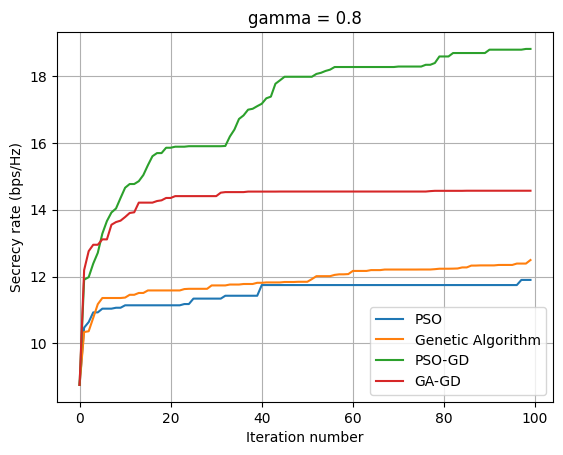

In [65]:
# iterations = range(0, num_cycles+10, 10)

iterations = range(0, 100)
# Extend the results to the same length
GD_results_draw = GD_results[:100]
PSO_results_draw = PSO_results[:100]
GA_results_draw = GA_results[:100]
PSO_GD_results_draw = PSO_GD_results[:100]
GA_GD_results_draw = GA_GD_results[:100]


#plt.plot(iterations, GD_results_draw, label='Gradient Descent')
plt.plot(iterations, PSO_results_draw, label='PSO')
plt.plot(iterations, GA_results_draw, label='Genetic Algorithm')
plt.plot(iterations, PSO_GD_results_draw, label='PSO-GD')
plt.plot(iterations, GA_GD_results_draw, label='GA-GD')

plt.xlabel('Iteration number')
plt.ylabel('Secrecy rate (bps/Hz)')
plt.title('gamma =', gamma)
plt.grid(True)
plt.legend()
plt.show()


In [64]:
# Best results of each methods
print("Best Secrecy Rate GD:", max(GD_results))
print("Best Secrecy Rate PSO:", max(PSO_results))
print("Best Secrecy Rate GA:", max(GA_results))
print("Best Secrecy Rate PSO-GD:", max(PSO_GD_results))
print("Best Secrecy Rate GA-GD:", max(GA_GD_results))

Best Secrecy Rate GD: 14.55176659777728
Best Secrecy Rate PSO: 12.476866173861348
Best Secrecy Rate GA: 13.457714097721054
Best Secrecy Rate PSO-GD: 19.42312619148822
Best Secrecy Rate GA-GD: 15.06870984347262
